# `x-ray-transmission.ipynb`

Author: Niels Vanderloo with inspiration from a MATLAB script by Jacob Pearcy

This notebook is used to plot and fit transmission data taken from the [Proto XRD system](https://leia.psfc.mit.edu/wiki/index.php/PROTO-XRD).


## Prerequisites
- MATLAB
  - [PhotonAttenuation](https://www.mathworks.com/matlabcentral/fileexchange/12092-photonattenuation) MATLAB module
- Uncommon Python packages:
  - `pip install mcareader`
  - `python -m pip install matlabengine`
  - `pip install xraydb` (optional, only used in last cell)

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
import numpy as np

In [2]:
import mcareader as mca
# can read MCA files directly
raw = mca.Mca("./7_20/baseline2_230720.mca")     # raw baseline data
filt = mca.Mca("./7_20/SRF2_window1_230720.mca")   # data with filter/sample

# get exposure time lengths for normalization (in seconds)
raw_exp = float(raw.get_variable("LIVE_TIME"))
filt_exp = float(filt.get_variable("LIVE_TIME"))

# extract just the data
raw = raw.get_points()
filt = filt.get_points()

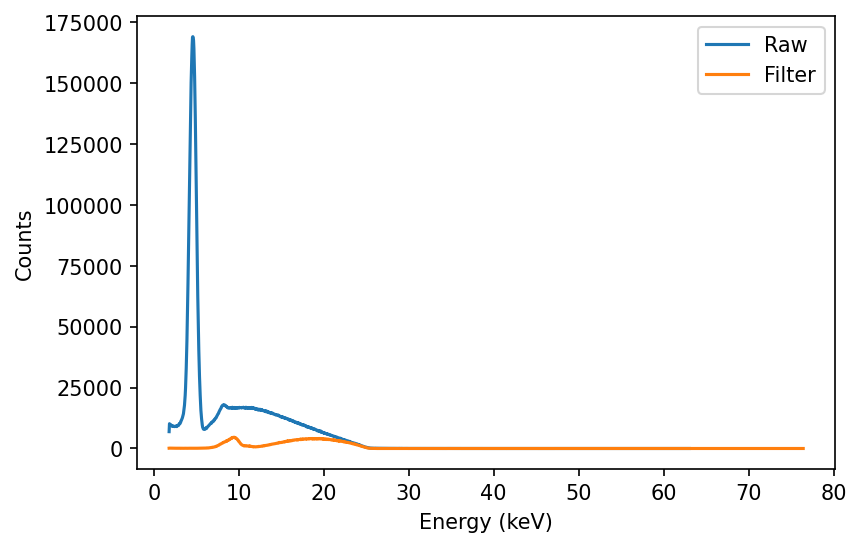

In [3]:
# plot the observed counts for raw and filtered data (not normalized by exposure time)
plt.plot(raw[0],raw[1], label="Raw")
plt.plot(filt[0],filt[1], label="Filter")
plt.xlabel("Energy (keV)")
plt.ylabel("Counts")
plt.legend()
plt.show()

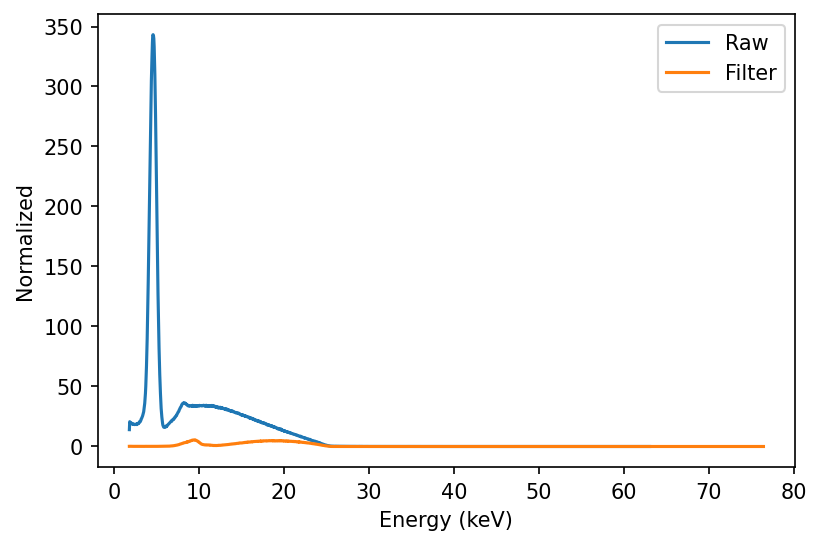

In [4]:
# normalize the data by the exposure time and plot
rawNorm = raw[1]/raw_exp
filtNorm = filt[1]/filt_exp

plt.plot(raw[0],rawNorm, label="Raw")
plt.plot(filt[0],filtNorm, label="Filter")
plt.xlabel("Energy (keV)")
plt.ylabel("Normalized")
plt.legend()
plt.show()

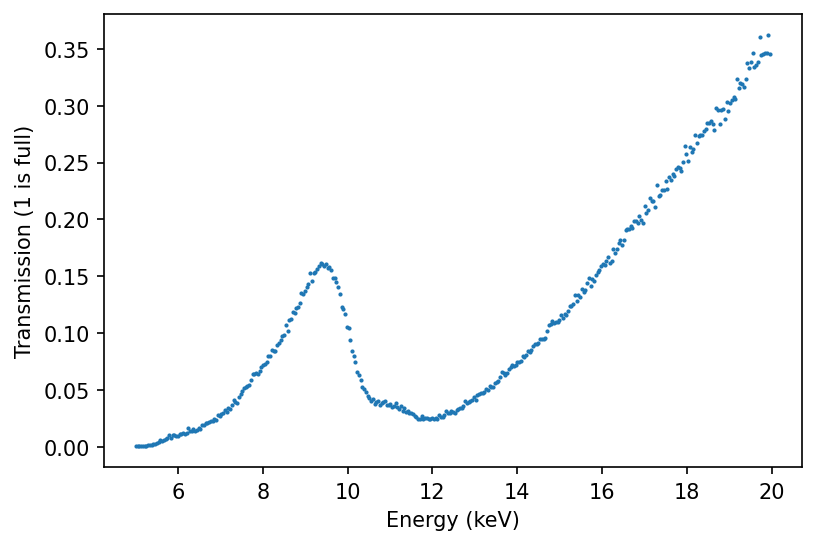

In [5]:
# Crop range of data (usually between 5 and 20 keV)
emin = 5 # keV
emax = 20  # keV
imin = np.argmin(np.abs(raw[0]-emin))
imax = np.argmin(np.abs(raw[0]-emax))

xAxis = raw[0][imin:imax]
raw_crop = raw[1][imin:imax]
filt_crop = filt[1][imin:imax]
rawNorm_crop = rawNorm[imin:imax]
filtNorm_crop = filtNorm[imin:imax]

plt.scatter(xAxis, filtNorm_crop/rawNorm_crop, s=1)
plt.xlabel("Energy (keV)")
plt.ylabel("Transmission (1 is full)")
plt.show()

In [6]:
# fit a thickness to the data
import matlab.engine
import xraydb as xr
from scipy.optimize import curve_fit

eng = matlab.engine.start_matlab()

# CHANGE 
# Material/element
# list of materials https://viewer.mathworks.com/?viewer=plain_code&url=https%3A%2F%2Fwww.mathworks.com%2Fmatlabcentral%2Fmlc-downloads%2Fdownloads%2Fsubmissions%2F12092%2Fversions%2F7%2Fcontents%2FPhysProps.m&embed=web

# material = 'Al' 
material = 'Ta'
# material = 'POLYPROPYLENE'

# CHANGE 
# initial guess range for thickness (for fitting procedure)
lowGuess = 0 # micron
highGuess = 30 # micron



def transmission(energy, thickness):
    if np.size(energy) == 1:
        return eng.PhotonAttenuation(material, energy*10**(-6), 5, thickness)
    else:
        return np.array([eng.PhotonAttenuation(material, e*10**(-6), 5, thickness) for e in energy])

# uncertainty analysis
f2 = np.square(filtNorm_crop/rawNorm_crop)
sigmaA = np.sqrt(filt_crop)/filt_exp
sigmaB = np.sqrt(raw_crop)/raw_exp
sigma = np.sqrt(f2*((sigmaA/filtNorm_crop)**2 + (sigmaB/rawNorm_crop)**2))

energies = xAxis*1e3 # convert to eV
popt, pcov = curve_fit(transmission, energies, filtNorm_crop/rawNorm_crop, bounds=(lowGuess*1e-4,highGuess*1e-4), sigma=sigma, absolute_sigma=True)

perr = np.sqrt(np.diag(pcov)) # error for fitted thickness
print("Material fit to:", material)
print("Fit Thickness = " + str(round(popt[0]*1e4, 3)) + "(" + str(round(perr[0]*1e4, 3)) + ") micron")

Material fit to: Ta
Fit Thickness = 9.736(0.006) micron


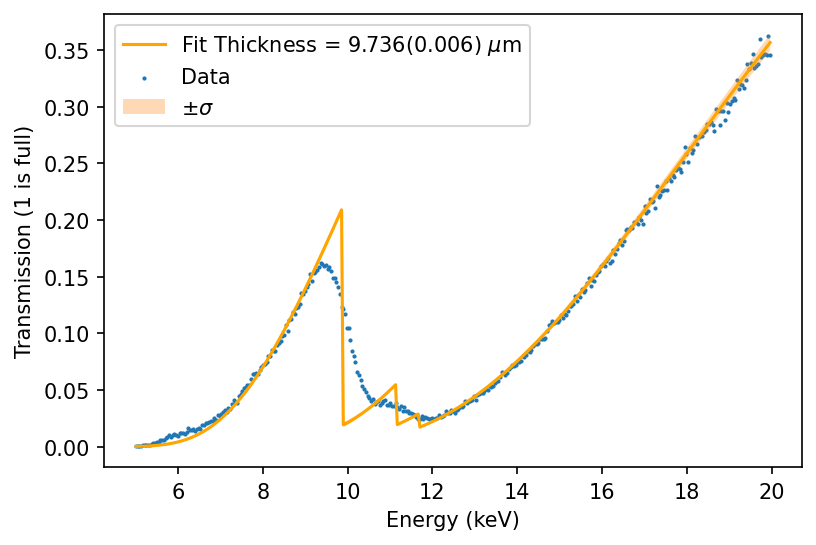

In [7]:
# plot the data and fit
plt.plot(xAxis, transmission(energies, *popt), label="Fit Thickness = " + str(round(popt[0]*1e4, 3)) + "(" + str(round(perr[0]*1e4, 3)) + ") $\mu$m", c='orange')
plt.scatter(xAxis, filtNorm_crop/rawNorm_crop, label="Data", s=1)
# 1 sigma error bars
plt.fill_between(xAxis, transmission(energies, *popt)-1*sigma, transmission(energies, *popt)+1*sigma, alpha=0.3, label="$\pm \sigma$")
plt.xlabel("Energy (keV)")
plt.ylabel("Transmission (1 is full)")
plt.legend()
plt.show()

In [10]:
# example code for calculating transmission fractions for a given material at a given energy
import xraydb as xr
import matlab.engine
eng = matlab.engine.start_matlab()

# list of materials for xraydb https://github.com/xraypy/XrayDB/blob/4c7ae7ec3278e24335bf487cef7a5b335fbb03d7/python/xraydb/materials.dat#L4
# list of materials for photonattenuation matlab module https://viewer.mathworks.com/?viewer=plain_code&url=https%3A%2F%2Fwww.mathworks.com%2Fmatlabcentral%2Fmlc-downloads%2Fdownloads%2Fsubmissions%2F12092%2Fversions%2F7%2Fcontents%2FPhysProps.m&embed=web

material = 'Ta' 
energy = 20.0e3 # eV
thickness = 26.4 # micron

transmission_xrdb = np.exp(-1*xr.material_mu(material, energy)*thickness*1e-4)
print("Transmission (x-ray db):", transmission_xrdb)

transmission_matlab = eng.PhotonAttenuation(material, energy*1e-6, 5, thickness*1e-4)
print("Transmission (matlab):", transmission_matlab)

Transmission (x-ray db): 0.061360536786319204
Transmission (matlab): 0.061780157631358454
